#Comparing Various Models for Multi-Class Classification for NLP Based Task
#Without GPU

###Author - Harsh Sharma


#Importing Important Libraries :

In [86]:
#Importing Important Libraries :
import csv
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional,Conv1D,MaxPool1D,MaxPooling1D,GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.utils import plot_model
from mlxtend.plotting import plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
import re
nltk.download('punkt')

!pip install prettytable
from prettytable import PrettyTable


import time



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Getting Dataset :
!wget --no-check-certificate \
    https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv \
    -O /tmp/bbc-text.csv

--2021-03-31 04:12:46--  https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.215.128, 173.194.216.128, 173.194.217.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.215.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [text/csv]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  --.-KB/s    in 0.02s   

2021-03-31 04:12:46 (231 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



In [ ]:
#Converting Dataset to Dataframe :
articles = []
labels = []

with open("/tmp/bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)
print(len(labels))
print(len(articles))

2225
2225


In [ ]:
raw_df=pd.DataFrame({"Text":articles,"Labels":labels})
raw_df

,Text,Labels
0,tv future hands viewers home theatre systems ...,tech
1,worldcom boss left books alone former worldc...,business
2,tigers wary farrell gamble leicester say rus...,sport
3,yeading face newcastle fa cup premiership side...,sport
4,ocean twelve raids box office ocean twelve cr...,entertainment
...,...,...
2220,cars pull us retail figures us retail sales fe...,business
2221,kilroy unveils immigration policy ex-chatshow ...,politics
2222,rem announce new glasgow concert us band rem a...,entertainment
2223,how political squabbles snowball become common...,politics


In [ ]:
#Inspecting our Dataframe :
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    2225 non-null   object
 1   Labels  2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [ ]:
#Getting Number of Unique Classes in our dataset :
raw_df.Labels.unique(),print("\n Total number of Unique Target Classes : ",raw_df.Labels.nunique())


 Total number of Unique Target Classes :  5


(array(['tech', 'business', 'sport', 'entertainment', 'politics'],
       dtype=object), None)

In [ ]:
# Text cleanup :
stemmer = PorterStemmer()

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
REMOVE_NUM = re.compile('[\d+]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
    text: a string
    return: modified initial string
    """
    # lowercase text
    text = text.lower() 

    # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    
    # Remove the XXXX values
    text = text.replace('x', '') 
    
    # Remove white space
    text = REMOVE_NUM.sub('', text)

    #  delete symbols which are in BAD_SYMBOLS_RE from text
    text = BAD_SYMBOLS_RE.sub('', text) 

    # delete stopwords from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    
    # removes any words composed of less than 2 or more than 21 letters
    text = ' '.join(word for word in text.split() if (len(word) >= 2 and len(word) <= 21))

    # Stemming the words
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    
    return text

In [ ]:
dataset=raw_df

In [ ]:
dataset['Text']=dataset['Text'].apply(clean_text)
dataset['Text']

0       tv futur hand viewer home theatr system plasma...
1       worldcom boss left book alon former worldcom b...
2       tiger wari farrel gambl leicest say rush make ...
3       yead face newcastl fa cup premiership side new...
4       ocean twelv raid bo offic ocean twelv crime ca...
                              ...                        
2220    car pull us retail figur us retail sale fell j...
2221    kilroy unveil immigr polici echatshow host rob...
2222    rem announc new glasgow concert us band rem an...
2223    polit squabbl snowbal becom commonplac argu bl...
2224    souness delight euro progress boss graem soune...
Name: Text, Length: 2225, dtype: object

In [ ]:
#Splitting raw data for Training and Testing :
text = dataset["Text"].values
labels = dataset['Labels'].values

X_train, y_train, X_test, y_test = train_test_split(text,labels, test_size = 0.20, random_state = 42)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)


(1780,) (1780,)
(445,) (445,)


In [ ]:
#Reshaping Labels Input :
X_test=X_test.reshape(-1,1)
y_test=y_test.reshape(-1,1)

print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)


(1780,) (1780, 1)
(445,) (445, 1)


In [ ]:
#Let's Fix Some Common Parameters :
# The maximum number of words to be used. (most frequent)
vocab_size = 50000

# Dimension of the dense embedding.
embedding_dim = 128

# Max number of words in each complaint.
max_length = 200

# Truncate and padding options
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [ ]:
# Tokenising , Converting Text To Sequences and Padding Our Data : 

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
word_index

Found 19057 unique tokens.


{'<OOV>': 1,
 'said': 2,
 'mr': 3,
 'year': 4,
 'would': 5,
 'also': 6,
 'new': 7,
 'peopl': 8,
 'us': 9,
 'one': 10,
 'game': 11,
 'say': 12,
 'use': 13,
 'could': 14,
 'time': 15,
 'last': 16,
 'make': 17,
 'first': 18,
 'net': 19,
 'go': 20,
 'govern': 21,
 'like': 22,
 'two': 23,
 'play': 24,
 'take': 25,
 'world': 26,
 'get': 27,
 'compani': 28,
 'film': 29,
 'work': 30,
 'uk': 31,
 'show': 32,
 'firm': 33,
 'music': 34,
 'back': 35,
 'bn': 36,
 'want': 37,
 'best': 38,
 'told': 39,
 'market': 40,
 'win': 41,
 'plan': 42,
 'made': 43,
 'includ': 44,
 'month': 45,
 'report': 46,
 'servic': 47,
 'set': 48,
 'come': 49,
 'number': 50,
 'ad': 51,
 'way': 52,
 'player': 53,
 'week': 54,
 'three': 55,
 'countri': 56,
 'need': 57,
 'mani': 58,
 'parti': 59,
 'bbc': 60,
 'labour': 61,
 'look': 62,
 'epect': 63,
 'home': 64,
 'elect': 65,
 'may': 66,
 'nation': 67,
 'sale': 68,
 'good': 69,
 'help': 70,
 'day': 71,
 'well': 72,
 'call': 73,
 'minist': 74,
 'technolog': 75,
 'million': 76,


In [ ]:
# Converting into Text to sequences and padding :
train_seq = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_seq = tokenizer.texts_to_sequences(y_train)
validation_padded = pad_sequences(validation_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)


In [ ]:
#Just an Example to see the raw sentance , sentance in sequences, sentance in sequences with padding:
X_train[3],train_seq[3],train_padded[3]

('school tribut tv host carson peopl turn sunday pay tribut late us tv present johnni carson nebraska town grew carson host tonight show year die januari respiratori diseas emphysema live norfolk nebraska age eight join navi return regularli donat local caus old school friend among crowd school johnni carson theater carson one bestlov tv person us ask public memori lo angel live later life began showbusi career norfolk perform magic name great carsoni age donat includ norfolk high school build new perform art centr carson die presid bush led public tribut say present profound influenc american life entertain',
 [406,
  1949,
  118,
  533,
  4422,
  8,
  256,
  400,
  263,
  1949,
  671,
  9,
  118,
  414,
  2424,
  4422,
  7885,
  2002,
  1396,
  4422,
  533,
  5529,
  32,
  4,
  788,
  314,
  12214,
  1915,
  12215,
  210,
  4423,
  7885,
  480,
  688,
  534,
  7886,
  188,
  2140,
  1054,
  395,
  613,
  689,
  406,
  879,
  429,
  1103,
  406,
  2424,
  4422,
  9366,
  4422,
  10,
 

In [ ]:
print('Shape of data tensor:', train_padded.shape)
print('Shape of data tensor:', validation_padded.shape)

Shape of data tensor: (1780, 200)
Shape of data tensor: (445, 200)


In [ ]:
#Using One Hot Enocder to Enocde our Multi class Labels  :
encode = OneHotEncoder()

training_labels = encode.fit_transform(X_test)
validation_labels = encode.transform(y_test)

In [ ]:
print(train_padded.shape)
print(validation_labels.shape)
print(validation_padded.shape)
print(training_labels.shape)
print(type(train_padded))
print(type(validation_padded))
print(type(training_labels))
print(type(validation_labels))



# The labels must be converted to arrays
# Convert the labels to arrays
training_labels = training_labels.toarray()
validation_labels = validation_labels.toarray()

print(type(training_labels))
print(type(validation_labels))


(1780, 200)
(445, 5)
(445, 200)
(1780, 5)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## Basic Functions for Plotting and Evaluation :

In [ ]:
def plot_graphs(history):
  plt.title('Loss VS Accuracy')
  plt.plot(history.history['loss'], label='train loss')
  plt.plot(history.history['val_loss'], label='test loss')
  plt.legend()
  
  plt.plot(history.history['accuracy'], label='train accuracy')
  plt.plot(history.history['val_accuracy'], label='test accuracy')
  plt.legend()
  plt.show();
  return None
def loss_graph(history):
  plt.title('Loss')
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend()
  plt.show();

  return None

def acc_graph(history):
  plt.title('Accuracy')
  plt.plot(history.history['accuracy'], label='train')
  plt.plot(history.history['val_accuracy'], label='test')
  plt.legend()
  plt.show();

  return None


def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels
    on a classification.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average='micro')
    recall = recall_score(y_true, y_preds, average='micro')
    f1 = f1_score(y_true, y_preds, average='micro')
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    
    return metric_dict

def model_eval(model,a,b,c,d):
  score=model.evaluate(a,b,verbose=0)
  score1=model.evaluate(c,d,verbose=0)
  print("\n")
  print("Model Loss on training data ",score[0])
  print("Model Accuracy on training data: ",score[1])
  print("Model Loss on validation data",score1[0])
  print("Model Accuracy on validation data: ",score1[1])
  print("\n")
  return score,score1

def model_eval(model,a,b,c,d):
  score=model.evaluate(a,b,verbose=0)
  score1=model.evaluate(c,d,verbose=0)
  print("\n")
  print("Model Loss on training data ",score[0])
  print("Model Accuracy on training data: ",score[1])
  print("Model Loss on validation data",score1[0])
  print("Model Accuracy on validation data: ",score1[1])
  print("\n")
  return score,score1



  

## Model Architectures :

In [ ]:
#Let's Fix Some Common Parameters :
# The maximum number of words to be used. 
vocab_size = 50000

# Dimension of the dense embedding.
embedding_dim = 128

# Max number of words in each complaint.
max_length = 200

# Truncate and padding options
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [ ]:
####TEST IN PROGRESS :


##Optimizers Used :
####Adam 
####AdaGrad
####SGD
####RMSPROP


1. Using Conv1D :

In [ ]:


tf.keras.backend.clear_session()
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))

model.add(Conv1D(48, 5, activation='relu', padding='valid'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 150
batch_size = 32
filepath="weights_best_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]
model.summary()
tf.keras.utils.plot_model(model)

history = model.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t1 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t1)
hist1=history




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 48)           30768     
_________________________________________________________________
global_max_pooling1d (Global (None, 48)                0         
_________________________________________________________________
dropout (Dropout)            (None, 48)                0         
_________________________________________________________________
flatten (Flatten)            (None, 48)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 2

In [ ]:
from tensorflow.keras.utils import plot_model

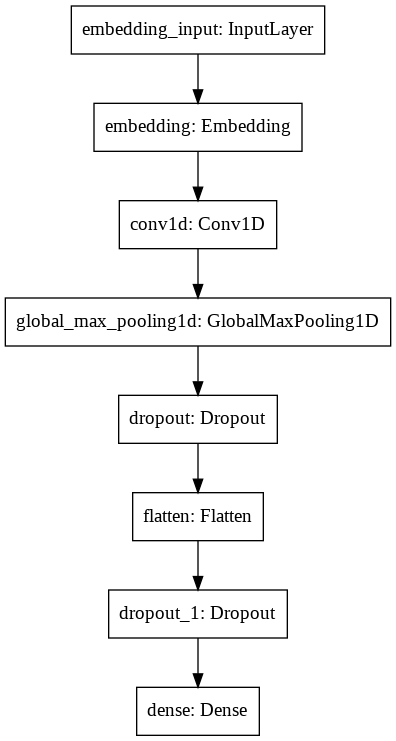

In [ ]:
plot_model(model)

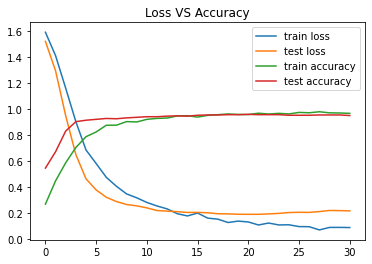

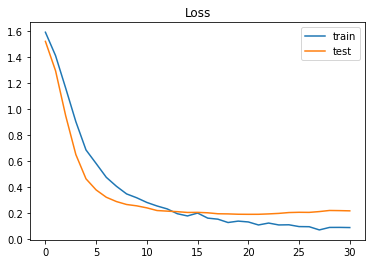

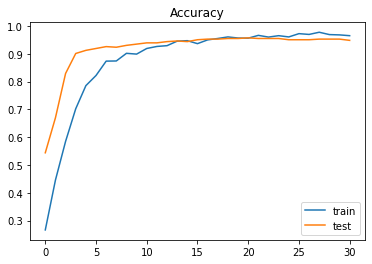

(None, None, None)

In [ ]:
plot_graphs(hist1),loss_graph(hist1),acc_graph(hist1)

In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 94.83%
Precision: 0.95
Recall: 0.95
F1 score: 0.95


{'accuracy': 0.95, 'f1': 0.95, 'precision': 0.95, 'recall': 0.95}

In [ ]:
# Testing Random Text and Predicted Classes :

original_text=raw_df['Text']
text = original_text[18]
new_text = [clean_text(text)]
print(text)
print(new_text)
seq = tokenizer.texts_to_sequences(new_text)
padded = pad_sequences(seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
pred = model.predict(padded)
acc = model.predict_proba(padded)
predicted_label = encode.inverse_transform(pred)
print('')
print(f'Product category id: {np.argmax(pred[0])}')
print(f'Predicted label is: {predicted_label[0]}')
print(f'Accuracy score: { acc.max() * 100}')

japanes bank battl end japan sumitomo mitsui financi withdrawn takeov offer rival bank ufj hold enabl latter merg mitsubishi tokyo sumitomo boss told counterpart ufj decis friday clear way conclud trillion yen bn deal mitsubishi deal would creat world biggest bank asset trillion yen trillion sumitomo eit end high profil fight japanes bank histori ufj hold japan fourthlargest bank centr fierc bid battl last year sumitomo japan thirdlargest bank tabl higher offer ufj rival valu compani bn howev ufj manag known prefer offer mitsubishi tokyo financi group mtfg japan secondlargest bank concern also rais sumitomo abil absorb ufj former admit defeat believ market investor accept ufjmtfg merger sumitomo said statement given ongo integr ufj mtfg oper persist propos may best interest sharehold ufj mitsubishi takeov ufj japan largestev takeov deal still approv sharehold two firm howev epect formal sumitomo may turn attent deepen tie daiwa secur anoth japanes financi firm two set merg ventur capit

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Epoch 1/150
56/56 [==============================] - 4s 61ms/step - loss: 1.6289 - accuracy: 0.1972 - val_loss: 1.6044 - val_accuracy: 0.2292

Epoch 00001: val_accuracy improved from -inf to 0.22921, saving model to weights_best_cnn.hdf5
Epoch 2/150
56/56 [==============================] - 3s 52ms/step - loss: 1.6142 - accuracy: 0.2138 - val_loss: 1.6002 - val_accuracy: 0.2719

Epoch 00002: val_accuracy improved from 0.22921 to 0.27191, saving model to weights_best_cnn.hdf5
Epoch 3/150
56/56 [==============================] - 3s 52ms/step - loss: 1.6096 - accuracy: 0.2329 - val_loss: 1.5970 - val_accuracy: 0.2764

Epoch 00003: val_accuracy improved from 0.27191 to 0.27640, saving model to weights_best_cnn.hdf5
Epoch 4/150
56/56 [==============================] - 3s 48ms/step - loss: 1.6018 - accuracy: 0.2523 - val_loss: 1.5941 - val_accuracy: 0.3303

Epoch 00004: val_accuracy improved from 0.27640 to 0.33034, saving model to weights_best_cnn.hdf5
Epoch 5/150
56/56 [====================

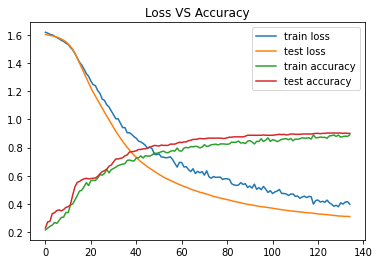

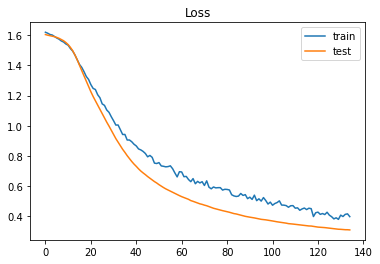

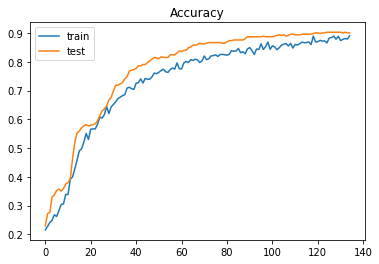

(None, None, None)

In [ ]:

# With AdaGrad
tf.keras.backend.clear_session()
model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))

model2.add(Conv1D(48, 5, activation='relu', padding='valid'))
model2.add(GlobalMaxPooling1D())
model2.add(Dropout(0.5))

model2.add(Flatten())
model2.add(Dropout(0.5))

model2.add(Dense(5, activation='softmax'))

optim=tf.keras.optimizers.Adagrad(
    learning_rate=0.01
    
)
model2.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

epochs = 150
batch_size = 32
filepath="weights_best_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model2.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t2 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t2)
hist2=history


plot_graphs(hist2),loss_graph(hist2),acc_graph(hist2)


In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model2.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 90.11%
Precision: 0.90
Recall: 0.90
F1 score: 0.90


{'accuracy': 0.9, 'f1': 0.9, 'precision': 0.9, 'recall': 0.9}

Epoch 1/150
56/56 [==============================] - 4s 54ms/step - loss: 1.6325 - accuracy: 0.1959 - val_loss: 1.6036 - val_accuracy: 0.2315

Epoch 00001: val_accuracy improved from -inf to 0.23146, saving model to weights_best_cnn.hdf5
Epoch 2/150
56/56 [==============================] - 3s 51ms/step - loss: 1.6097 - accuracy: 0.2272 - val_loss: 1.6011 - val_accuracy: 0.2315

Epoch 00002: val_accuracy did not improve from 0.23146
Epoch 3/150
56/56 [==============================] - 3s 48ms/step - loss: 1.5911 - accuracy: 0.2370 - val_loss: 1.5991 - val_accuracy: 0.2315

Epoch 00003: val_accuracy did not improve from 0.23146
Epoch 4/150
56/56 [==============================] - 3s 47ms/step - loss: 1.5947 - accuracy: 0.2483 - val_loss: 1.5969 - val_accuracy: 0.2584

Epoch 00004: val_accuracy improved from 0.23146 to 0.25843, saving model to weights_best_cnn.hdf5
Epoch 5/150
56/56 [==============================] - 3s 46ms/step - loss: 1.5982 - accuracy: 0.2333 - val_loss: 1.5945 - val_

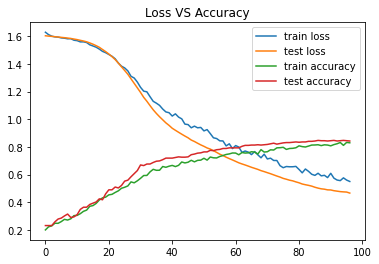

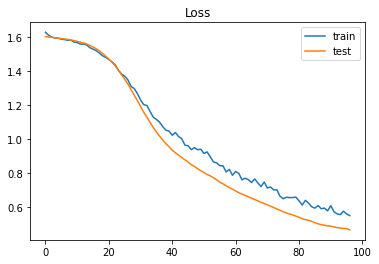

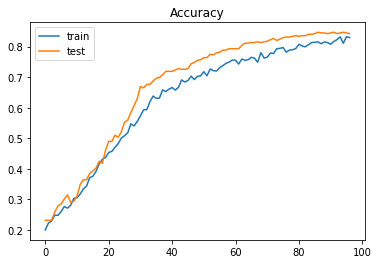

(None, None, None)

In [ ]:

# With SGD
tf.keras.backend.clear_session()
model3 = Sequential()
model3.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))

model3.add(Conv1D(48, 5, activation='relu', padding='valid'))
model3.add(GlobalMaxPooling1D())
model3.add(Dropout(0.5))

model3.add(Flatten())
model3.add(Dropout(0.5))

model3.add(Dense(5, activation='softmax'))

optim=tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.5, nesterov=True, name="SGD"
)
model3.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

epochs = 150
batch_size = 32
filepath="weights_best_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model3.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t3 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t3)
hist3=history


plot_graphs(hist3),loss_graph(hist3),acc_graph(hist3)


In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model3.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 84.27%
Precision: 0.84
Recall: 0.84
F1 score: 0.84


{'accuracy': 0.84, 'f1': 0.84, 'precision': 0.84, 'recall': 0.84}

Epoch 1/150
56/56 [==============================] - 5s 72ms/step - loss: 1.3780 - accuracy: 0.4261 - val_loss: 0.3461 - val_accuracy: 0.9034

Epoch 00001: val_accuracy improved from -inf to 0.90337, saving model to weights_best_cnn.hdf5
Epoch 2/150
56/56 [==============================] - 4s 71ms/step - loss: 0.5813 - accuracy: 0.8073 - val_loss: 0.2302 - val_accuracy: 0.9348

Epoch 00002: val_accuracy improved from 0.90337 to 0.93483, saving model to weights_best_cnn.hdf5
Epoch 3/150
56/56 [==============================] - 4s 69ms/step - loss: 0.3365 - accuracy: 0.8879 - val_loss: 0.2163 - val_accuracy: 0.9371

Epoch 00003: val_accuracy improved from 0.93483 to 0.93708, saving model to weights_best_cnn.hdf5
Epoch 4/150
56/56 [==============================] - 4s 74ms/step - loss: 0.2810 - accuracy: 0.8986 - val_loss: 0.2560 - val_accuracy: 0.9371

Epoch 00004: val_accuracy did not improve from 0.93708
Epoch 5/150
56/56 [==============================] - 4s 69ms/step - loss: 0.2076 -

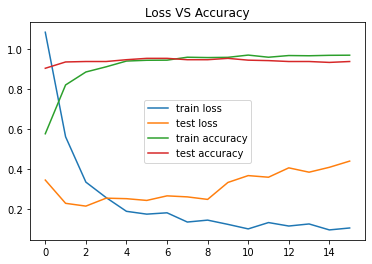

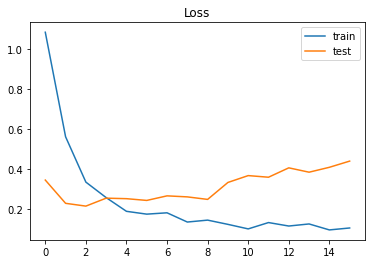

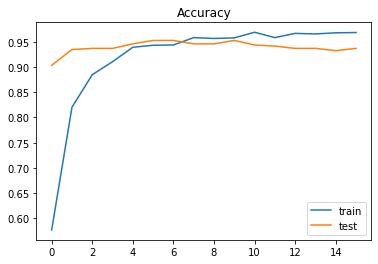

(None, None, None)

In [ ]:

# With RMSPROP
tf.keras.backend.clear_session()
model4 = Sequential()
model4.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))

model4.add(Conv1D(48, 5, activation='relu', padding='valid'))
model4.add(GlobalMaxPooling1D())
model4.add(Dropout(0.5))

model4.add(Flatten())
model4.add(Dropout(0.5))

model4.add(Dense(5, activation='softmax'))

optim=tf.keras.optimizers.RMSprop(
    learning_rate=0.01
    
)
model4.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

epochs = 150
batch_size = 32
filepath="weights_best_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model4.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t4 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t4)
hist4=history


plot_graphs(hist4),loss_graph(hist4),acc_graph(hist4)


In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model4.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 93.71%
Precision: 0.94
Recall: 0.94
F1 score: 0.94


{'accuracy': 0.94, 'f1': 0.94, 'precision': 0.94, 'recall': 0.94}

Epoch 1/150
56/56 [==============================] - 4s 54ms/step - loss: 1.6223 - accuracy: 0.2051 - val_loss: 1.6097 - val_accuracy: 0.2157

Epoch 00001: val_accuracy improved from -inf to 0.21573, saving model to weights_best_cnn.hdf5
Epoch 2/150
56/56 [==============================] - 3s 49ms/step - loss: 1.6321 - accuracy: 0.1979 - val_loss: 1.6093 - val_accuracy: 0.2180

Epoch 00002: val_accuracy improved from 0.21573 to 0.21798, saving model to weights_best_cnn.hdf5
Epoch 3/150
56/56 [==============================] - 3s 52ms/step - loss: 1.6229 - accuracy: 0.2080 - val_loss: 1.6088 - val_accuracy: 0.2180

Epoch 00003: val_accuracy did not improve from 0.21798
Epoch 4/150
56/56 [==============================] - 3s 49ms/step - loss: 1.6327 - accuracy: 0.1787 - val_loss: 1.6084 - val_accuracy: 0.2180

Epoch 00004: val_accuracy did not improve from 0.21798
Epoch 5/150
56/56 [==============================] - 3s 52ms/step - loss: 1.6140 - accuracy: 0.2293 - val_loss: 1.6080 - val_

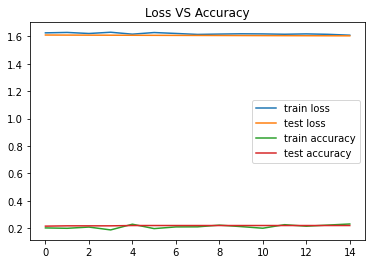

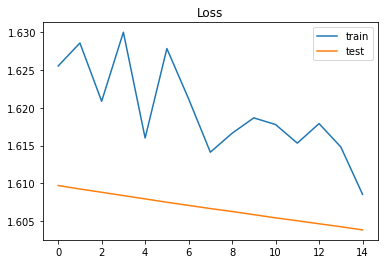

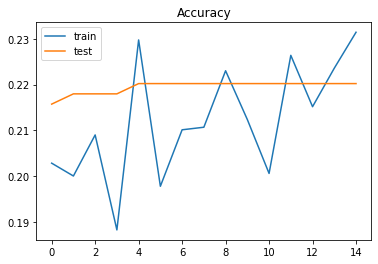

(None, None, None)

In [ ]:

# With Adadelta
tf.keras.backend.clear_session()

model5 = Sequential()
model5.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))

model5.add(Conv1D(48, 5, activation='relu', padding='valid'))
model5.add(GlobalMaxPooling1D())
model5.add(Dropout(0.5))

model5.add(Flatten())
model5.add(Dropout(0.5))

model5.add(Dense(5, activation='softmax'))

optim=tf.keras.optimizers.Adadelta(
    learning_rate=0.01
)
model5.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

epochs = 150
batch_size = 32
filepath="weights_best_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model5.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t5 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t5)
hist5=history


plot_graphs(hist5),loss_graph(hist5),acc_graph(hist5)


In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model5.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 22.02%
Precision: 0.22
Recall: 0.22
F1 score: 0.22


{'accuracy': 0.22, 'f1': 0.22, 'precision': 0.22, 'recall': 0.22}

2.Using LSTMs :

In [ ]:

tf.keras.backend.clear_session()
model6 = Sequential()

model6.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model6.add(Dropout(0.5))
model6.add(LSTM(embedding_dim))
model6.add(Dense(5, activation='softmax'))

model6.summary()

model6.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_lstms.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model6.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t6 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t6)
hist6=history

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
dropout (Dropout)            (None, 200, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 6,532,229
Trainable params: 6,532,229
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 21s 337ms/step - loss: 1.5563 - accuracy: 0.2836 - val_loss: 1.4643 - val_accuracy: 0.2764

Epoch 00001: val_accuracy improved from -inf to 0.27640, saving model to weights_best_lstms.hdf5
Ep

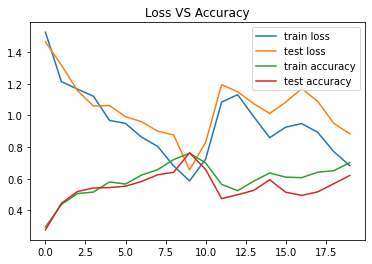

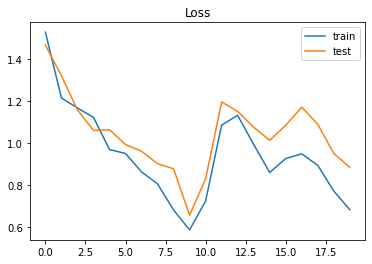

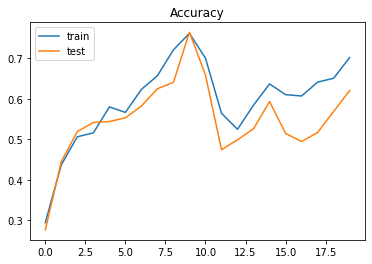

(None, None, None)

In [ ]:
plot_graphs(hist6),loss_graph(hist6),acc_graph(hist6)

In [ ]:
predicted = model6.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))

Acc: 62.02%
Precision: 0.62
Recall: 0.62
F1 score: 0.62


{'accuracy': 0.62, 'f1': 0.62, 'precision': 0.62, 'recall': 0.62}

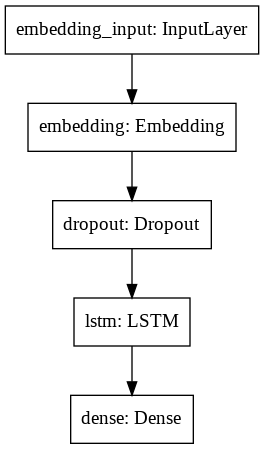

In [87]:
plot_model(model6)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
dropout (Dropout)            (None, 200, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 6,532,229
Trainable params: 6,532,229
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 18s 278ms/step - loss: 1.6022 - accuracy: 0.2364 - val_loss: 1.5863 - val_accuracy: 0.2427

Epoch 00001: val_accuracy improved from -inf to 0.24270, saving model to weights_best_lstms.hdf5
Ep

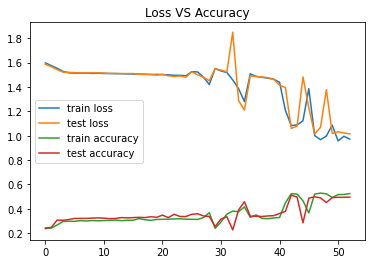

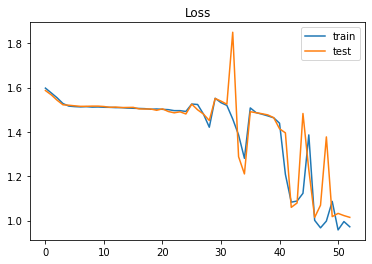

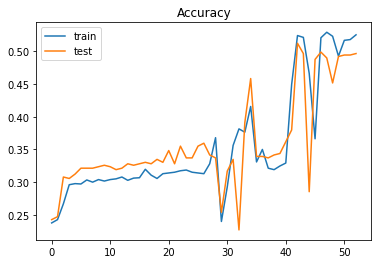

(None, None, None)

In [ ]:

#With Adagrad :
tf.keras.backend.clear_session()
model7 = Sequential()

model7.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model7.add(Dropout(0.5))
model7.add(LSTM(embedding_dim))
model7.add(Dense(5, activation='softmax'))

model7.summary()
optim=tf.keras.optimizers.Adagrad(
    learning_rate=0.01
)
model7.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_lstms.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model7.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t7 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t7)
hist7=history

plot_graphs(hist7),loss_graph(hist7),acc_graph(hist7)

In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model7.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 49.66%
Precision: 0.50
Recall: 0.50
F1 score: 0.50


{'accuracy': 0.5, 'f1': 0.5, 'precision': 0.5, 'recall': 0.5}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
dropout (Dropout)            (None, 200, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 6,532,229
Trainable params: 6,532,229
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 19s 299ms/step - loss: 1.6044 - accuracy: 0.2003 - val_loss: 1.5959 - val_accuracy: 0.2157

Epoch 00001: val_accuracy improved from -inf to 0.21573, saving model to weights_best_lstms.hdf5
Ep

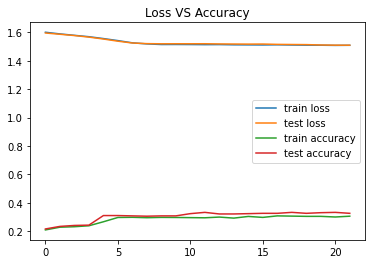

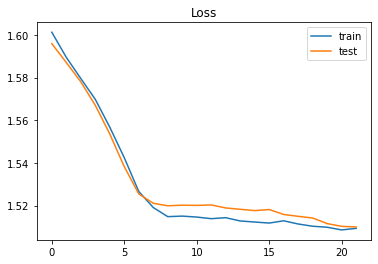

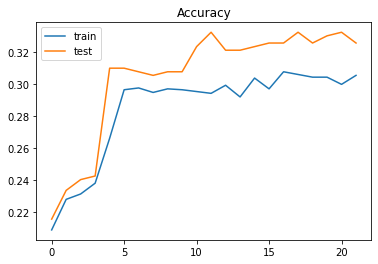

(None, None, None)

In [ ]:

#With SGD :
tf.keras.backend.clear_session()
model8 = Sequential()

model8.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model8.add(Dropout(0.5))
model8.add(LSTM(embedding_dim))
model8.add(Dense(5, activation='softmax'))

model8.summary()
optim=tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.5, nesterov=True, name="SGD"
)
model8.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_lstms.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model8.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t8 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t8)
hist8=history

plot_graphs(hist8),loss_graph(hist8),acc_graph(hist8)

In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model8.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 32.58%
Precision: 0.33
Recall: 0.33
F1 score: 0.33


{'accuracy': 0.33, 'f1': 0.33, 'precision': 0.33, 'recall': 0.33}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
dropout (Dropout)            (None, 200, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 6,532,229
Trainable params: 6,532,229
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 19s 302ms/step - loss: 1.6776 - accuracy: 0.2250 - val_loss: 1.5597 - val_accuracy: 0.2427

Epoch 00001: val_accuracy improved from -inf to 0.24270, saving model to weights_best_lstms.hdf5
Ep

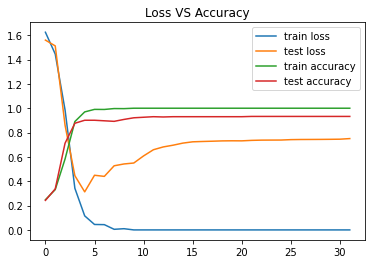

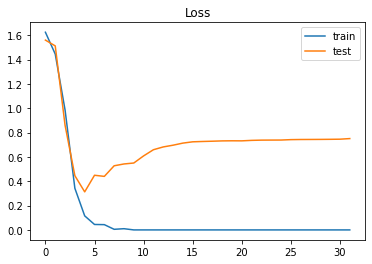

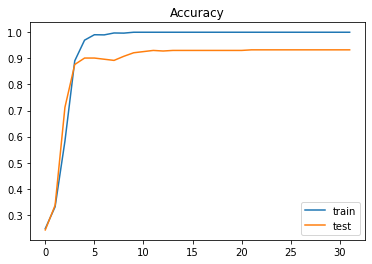

(None, None, None)

In [ ]:

#With RMSProp :
tf.keras.backend.clear_session()
model9 = Sequential()

model9.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model9.add(Dropout(0.5))
model9.add(LSTM(embedding_dim))
model9.add(Dense(5, activation='softmax'))

model9.summary()
optim=tf.keras.optimizers.RMSprop(
    learning_rate=0.01
)
model9.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_lstms.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model9.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t9 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t9)
hist9=history

plot_graphs(hist9),loss_graph(hist9),acc_graph(hist9)

In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model9.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 93.26%
Precision: 0.93
Recall: 0.93
F1 score: 0.93


{'accuracy': 0.93, 'f1': 0.93, 'precision': 0.93, 'recall': 0.93}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
dropout (Dropout)            (None, 200, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 6,532,229
Trainable params: 6,532,229
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 17s 276ms/step - loss: 1.6078 - accuracy: 0.1930 - val_loss: 1.6066 - val_accuracy: 0.2539

Epoch 00001: val_accuracy improved from -inf to 0.25393, saving model to weights_best_lstms.hdf5
Ep

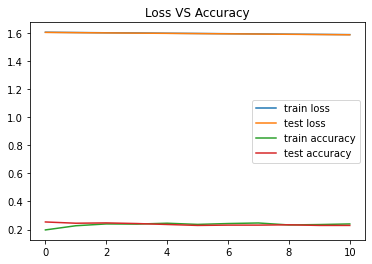

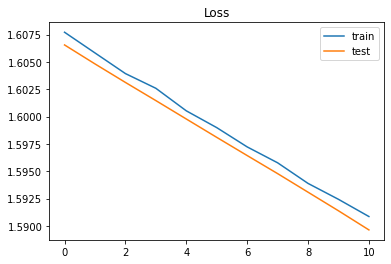

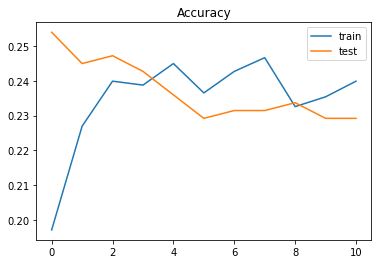

(None, None, None)

In [ ]:

#With Adadelta :
tf.keras.backend.clear_session()
model10 = Sequential()

model10.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model10.add(Dropout(0.5))
model10.add(LSTM(embedding_dim))
model10.add(Dense(5, activation='softmax'))

model10.summary()
optim=tf.keras.optimizers.Adadelta(
    learning_rate=0.01)
model10.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_lstms.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model10.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t10 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t10)
hist10=history

plot_graphs(hist10),loss_graph(hist10),acc_graph(hist10)

In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model10.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 22.92%
Precision: 0.23
Recall: 0.23
F1 score: 0.23


{'accuracy': 0.23, 'f1': 0.23, 'precision': 0.23, 'recall': 0.23}

3.Using Bi-Directional LSTMs :

In [ ]:

tf.keras.backend.clear_session()
model11 = Sequential()

model11.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model11.add(Dropout(0.5))
model11.add(Bidirectional(LSTM(embedding_dim)))
model11.add(Dense(5, activation='softmax'))

model11.summary()

model11.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_bi_lstms.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model11.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t11 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t11)
hist11=history

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
dropout (Dropout)            (None, 200, 128)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 6,664,453
Trainable params: 6,664,453
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 37s 592ms/step - loss: 1.5160 - accuracy: 0.2970 - val_loss: 1.0728 - val_accuracy: 0.6674

Epoch 00001: val_accuracy improved from -inf to 0.66742, saving model to weights_best_bi_lstms.hdf5

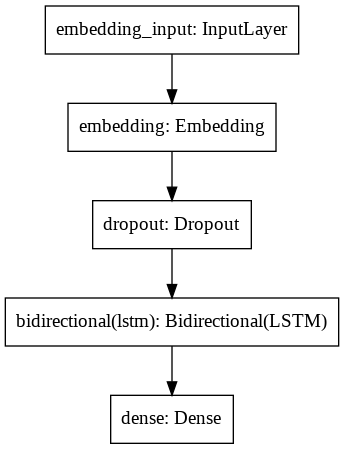

In [88]:
plot_model(model11)

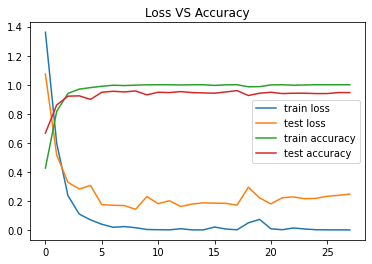

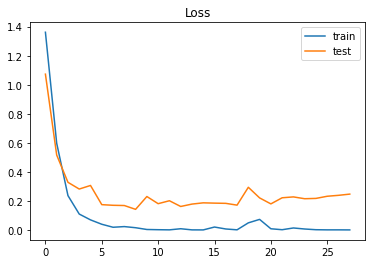

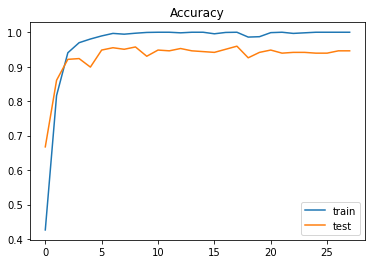

(None, None, None)

In [ ]:
plot_graphs(hist11),loss_graph(hist11),acc_graph(hist11)

In [ ]:
predicted = model11.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))

Acc: 94.61%
Precision: 0.95
Recall: 0.95
F1 score: 0.95


{'accuracy': 0.95, 'f1': 0.95, 'precision': 0.95, 'recall': 0.95}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
dropout (Dropout)            (None, 200, 128)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 6,664,453
Trainable params: 6,664,453
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 32s 513ms/step - loss: 1.6063 - accuracy: 0.2075 - val_loss: 1.5959 - val_accuracy: 0.2135

Epoch 00001: val_accuracy improved from -inf to 0.21348, saving model to weights_best_bi_lstms.hdf5

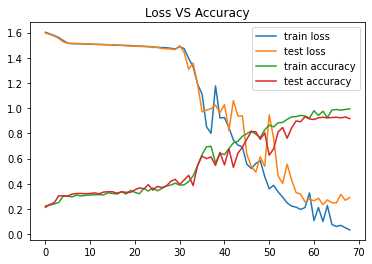

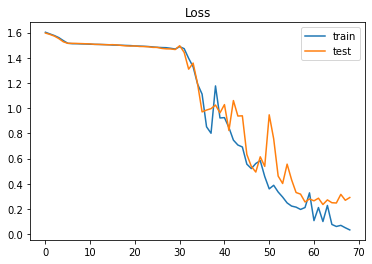

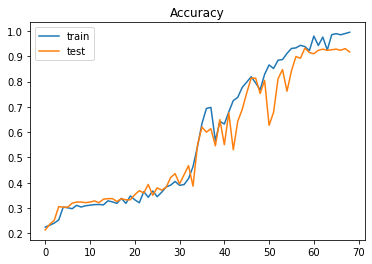

(None, None, None)

In [ ]:
#with Adagrad
tf.keras.backend.clear_session()
model12 = Sequential()

model12.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model12.add(Dropout(0.5))
model12.add(Bidirectional(LSTM(embedding_dim)))
model12.add(Dense(5, activation='softmax'))

model12.summary()
optim=tf.keras.optimizers.Adagrad(
    learning_rate=0.01
)
model12.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_bi_lstms.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model12.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t12 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t12)
hist12=history

plot_graphs(hist12),loss_graph(hist12),acc_graph(hist12)

In [53]:
# Now we make predictions using the test data to see how the model performs

predicted = model12.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 91.69%
Precision: 0.92
Recall: 0.92
F1 score: 0.92


{'accuracy': 0.92, 'f1': 0.92, 'precision': 0.92, 'recall': 0.92}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
dropout (Dropout)            (None, 200, 128)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 6,664,453
Trainable params: 6,664,453
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 31s 503ms/step - loss: 1.6083 - accuracy: 0.2184 - val_loss: 1.6022 - val_accuracy: 0.2337

Epoch 00001: val_accuracy improved from -inf to 0.23371, saving model to weights_best_bi_lstms.hdf5

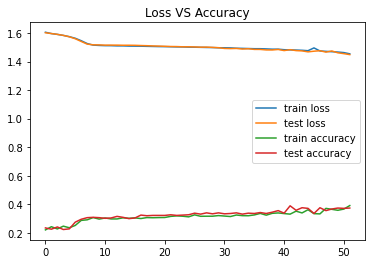

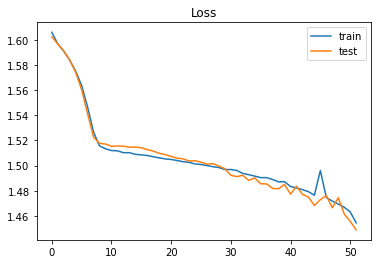

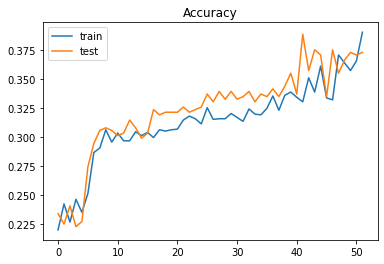

(None, None, None)

In [54]:
#with SGD
tf.keras.backend.clear_session()
model13 = Sequential()

model13.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model13.add(Dropout(0.5))
model13.add(Bidirectional(LSTM(embedding_dim)))
model13.add(Dense(5, activation='softmax'))

model13.summary()
optim=tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.5, nesterov=True, name="SGD"
)
model13.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_bi_lstms.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model13.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t13 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t13)
hist13=history

plot_graphs(hist13),loss_graph(hist13),acc_graph(hist13)

In [55]:
# Now we make predictions using the test data to see how the model performs

predicted = model13.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 37.30%
Precision: 0.37
Recall: 0.37
F1 score: 0.37


{'accuracy': 0.37, 'f1': 0.37, 'precision': 0.37, 'recall': 0.37}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
dropout (Dropout)            (None, 200, 128)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 6,664,453
Trainable params: 6,664,453
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 36s 562ms/step - loss: 1.9134 - accuracy: 0.2736 - val_loss: 1.1274 - val_accuracy: 0.5573

Epoch 00001: val_accuracy improved from -inf to 0.55730, saving model to weights_best_bi_lstms.hdf5

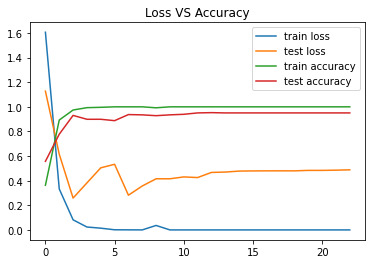

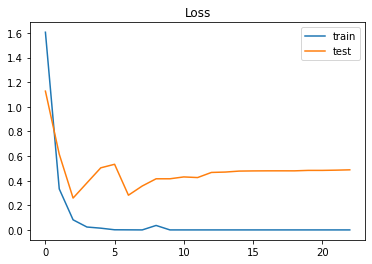

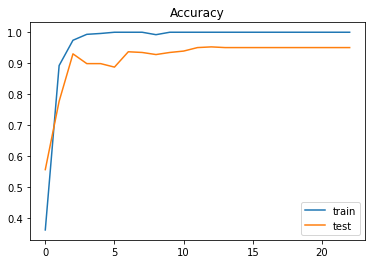

(None, None, None)

In [56]:
#with RMSProp
tf.keras.backend.clear_session()
model14 = Sequential()

model14.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model14.add(Dropout(0.5))
model14.add(Bidirectional(LSTM(embedding_dim)))
model14.add(Dense(5, activation='softmax'))

model14.summary()
optim=tf.keras.optimizers.RMSprop(
    learning_rate=0.01
)
model14.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_bi_lstms.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model14.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t14 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t14)
hist14=history

plot_graphs(hist14),loss_graph(hist14),acc_graph(hist14)

In [57]:
# Now we make predictions using the test data to see how the model performs

predicted = model14.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 95.06%
Precision: 0.95
Recall: 0.95
F1 score: 0.95


{'accuracy': 0.95, 'f1': 0.95, 'precision': 0.95, 'recall': 0.95}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
dropout (Dropout)            (None, 200, 128)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 6,664,453
Trainable params: 6,664,453
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 32s 510ms/step - loss: 1.6067 - accuracy: 0.2254 - val_loss: 1.6049 - val_accuracy: 0.2539

Epoch 00001: val_accuracy improved from -inf to 0.25393, saving model to weights_best_bi_lstms.hdf5

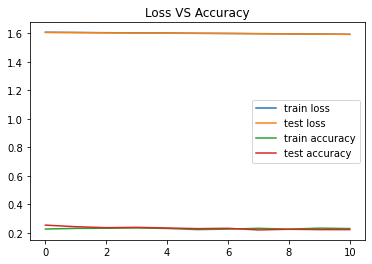

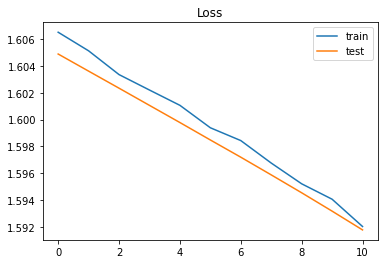

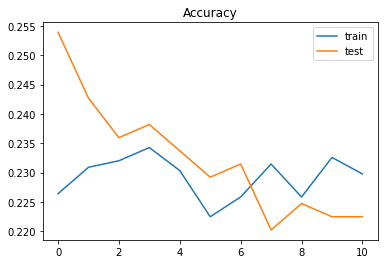

(None, None, None)

In [58]:
#with Adadelta
tf.keras.backend.clear_session()
model15 = Sequential()

model15.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model15.add(Dropout(0.5))
model15.add(Bidirectional(LSTM(embedding_dim)))
model15.add(Dense(5, activation='softmax'))

model15.summary()
optim=tf.keras.optimizers.Adadelta(
    learning_rate=0.01
)
model15.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_bi_lstms.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model15.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t15 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t15)
hist15=history

plot_graphs(hist15),loss_graph(hist15),acc_graph(hist15)

In [59]:
# Now we make predictions using the test data to see how the model performs

predicted = model15.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 22.25%
Precision: 0.22
Recall: 0.22
F1 score: 0.22


{'accuracy': 0.22, 'f1': 0.22, 'precision': 0.22, 'recall': 0.22}

4.Using CNN1D + LSTMs :

In [60]:

tf.keras.backend.clear_session()
model16 = Sequential()

model16.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model16.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model16.add(MaxPooling1D(pool_size=2))
model16.add(LSTM(embedding_dim))
model16.add(Dense(5, activation='softmax'))

model16.summary()

model16.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_lstms_n_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model16.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t16 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t16)
hist16=history

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 32)           12320     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 6,495,397
Trainable params: 6,495,397
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 14s 218ms/step - loss: 1.5239 - accuracy: 0.3062 - val_loss

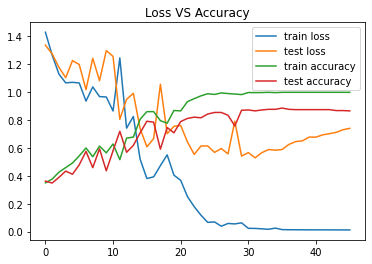

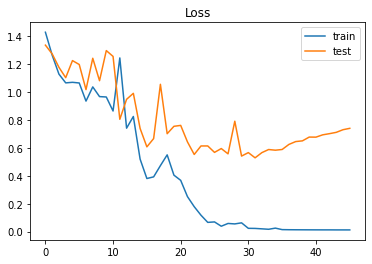

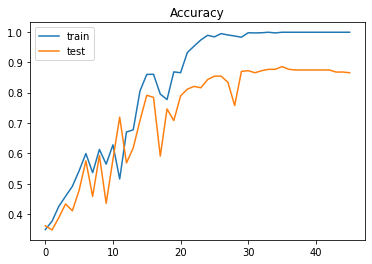

(None, None, None)

In [61]:
plot_graphs(hist16),loss_graph(hist16),acc_graph(hist16)

In [62]:
predicted = model16.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))

Acc: 86.52%
Precision: 0.87
Recall: 0.87
F1 score: 0.87


{'accuracy': 0.87, 'f1': 0.87, 'precision': 0.87, 'recall': 0.87}

In [ ]:

tf.keras.backend.clear_session()
model16 = Sequential()

model16.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model16.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model16.add(MaxPooling1D(pool_size=2))
model16.add(LSTM(embedding_dim))
model16.add(Dense(5, activation='softmax'))

model16.summary()
optim=#OPTIMIZER
model16.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_lstms_n_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model16.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t16 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t16)
hist16=history

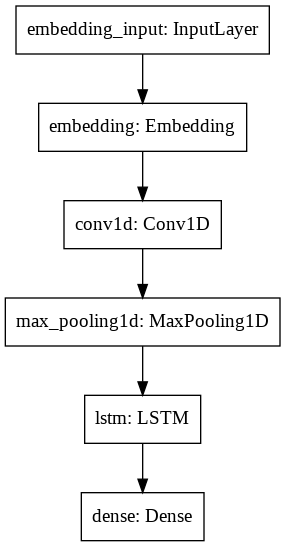

In [89]:
plot_model(model16)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 32)           12320     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 6,495,397
Trainable params: 6,495,397
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 11s 150ms/step - loss: 1.6042 - accuracy: 0.2187 - val_loss

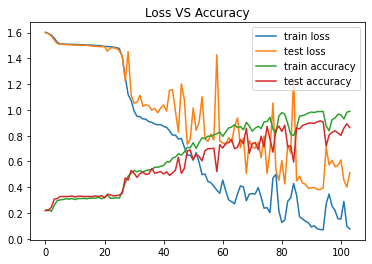

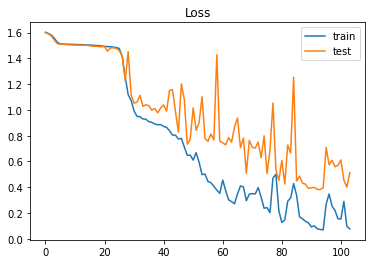

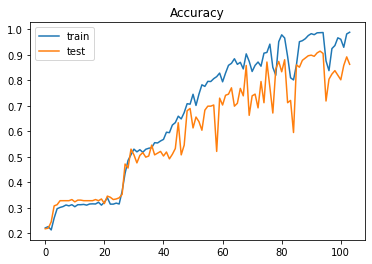

(None, None, None)

In [63]:
#With AdaGrad
tf.keras.backend.clear_session()
model17 = Sequential()

model17.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model17.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model17.add(MaxPooling1D(pool_size=2))
model17.add(LSTM(embedding_dim))
model17.add(Dense(5, activation='softmax'))

model17.summary()
optim=tf.keras.optimizers.Adagrad(
    learning_rate=0.01
)
model17.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_lstms_n_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model17.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t17 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t17)
hist17=history

plot_graphs(hist17),loss_graph(hist17),acc_graph(hist17)

In [64]:
# Now we make predictions using the test data to see how the model performs

predicted = model17.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 86.29%
Precision: 0.86
Recall: 0.86
F1 score: 0.86


{'accuracy': 0.86, 'f1': 0.86, 'precision': 0.86, 'recall': 0.86}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 32)           12320     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 6,495,397
Trainable params: 6,495,397
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 12s 171ms/step - loss: 1.6075 - accuracy: 0.2237 - val_loss

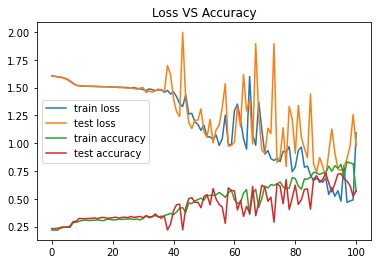

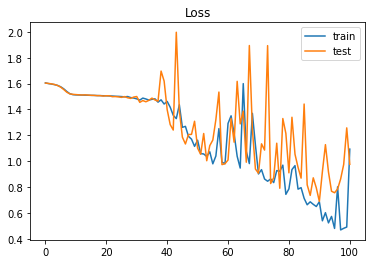

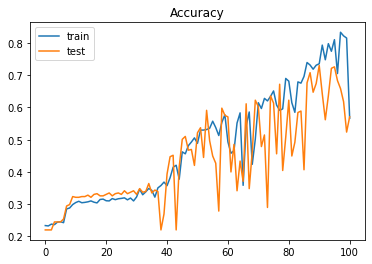

(None, None, None)

In [65]:
#With SGD
tf.keras.backend.clear_session()
model18 = Sequential()

model18.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model18.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model18.add(MaxPooling1D(pool_size=2))
model18.add(LSTM(embedding_dim))
model18.add(Dense(5, activation='softmax'))

model18.summary()
optim=tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.5, nesterov=True, name="SGD"
)
model18.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_lstms_n_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model18.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t18 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t18)
hist18=history

plot_graphs(hist18),loss_graph(hist18),acc_graph(hist18)

In [66]:
# Now we make predictions using the test data to see how the model performs

predicted = model18.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 57.08%
Precision: 0.57
Recall: 0.57
F1 score: 0.57


{'accuracy': 0.57, 'f1': 0.57, 'precision': 0.57, 'recall': 0.57}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 32)           12320     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 6,495,397
Trainable params: 6,495,397
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 12s 180ms/step - loss: 1.7080 - accuracy: 0.2453 - val_loss

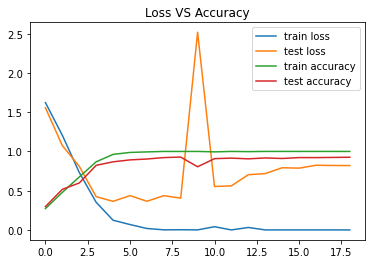

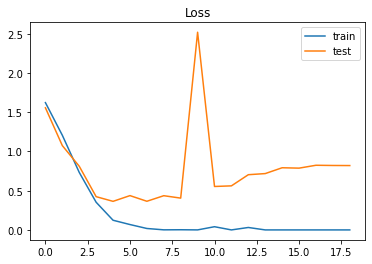

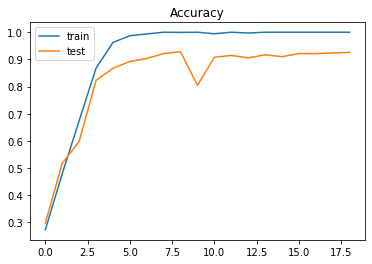

(None, None, None)

In [67]:
#With RMSprop
tf.keras.backend.clear_session()
model19 = Sequential()

model19.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model19.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model19.add(MaxPooling1D(pool_size=2))
model19.add(LSTM(embedding_dim))
model19.add(Dense(5, activation='softmax'))

model19.summary()
optim=tf.keras.optimizers.RMSprop(
    learning_rate=0.01
)
model19.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_lstms_n_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model19.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t19 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t19)
hist19=history

plot_graphs(hist19),loss_graph(hist19),acc_graph(hist19)

In [68]:
# Now we make predictions using the test data to see how the model performs

predicted = model19.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 92.58%
Precision: 0.93
Recall: 0.93
F1 score: 0.93


{'accuracy': 0.93, 'f1': 0.93, 'precision': 0.93, 'recall': 0.93}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 32)           12320     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 6,495,397
Trainable params: 6,495,397
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 11s 155ms/step - loss: 1.6106 - accuracy: 0.1769 - val_loss

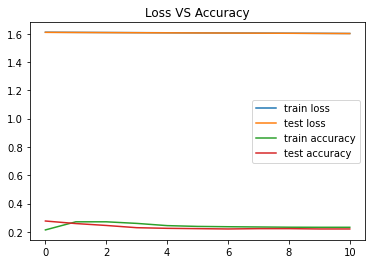

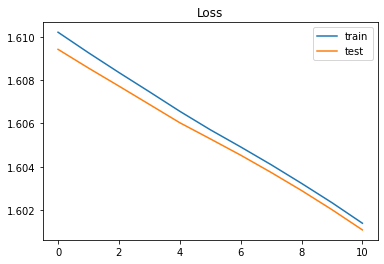

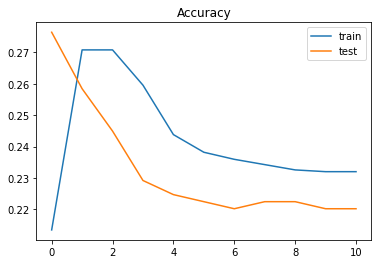

(None, None, None)

In [69]:
#With AdaDelta
tf.keras.backend.clear_session()
model20 = Sequential()

model20.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model20.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model20.add(MaxPooling1D(pool_size=2))
model20.add(LSTM(embedding_dim))
model20.add(Dense(5, activation='softmax'))

model20.summary()
optim=tf.keras.optimizers.Adadelta(
    learning_rate=0.01
)
model20.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_lstms_n_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model20.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t20 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t20)
hist20=history

plot_graphs(hist20),loss_graph(hist20),acc_graph(hist20)

In [70]:
# Now we make predictions using the test data to see how the model performs

predicted = model20.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 22.02%
Precision: 0.22
Recall: 0.22
F1 score: 0.22


{'accuracy': 0.22, 'f1': 0.22, 'precision': 0.22, 'recall': 0.22}

5.Using Bi_LSTMs + CNN1D :

In [71]:

tf.keras.backend.clear_session()
model21 = Sequential()

model21.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model21.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model21.add(MaxPooling1D(pool_size=2))
model21.add(Bidirectional(LSTM(embedding_dim)))
model21.add(Dense(5, activation='softmax'))

model21.summary()

model21.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_bi_lstms_n_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model21.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t21 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t21)
hist21=history

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 32)           12320     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 32)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               164864    
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 6,578,469
Trainable params: 6,578,469
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 24s 363ms/step - loss: 1.5216 - accuracy: 0.2931 - val_loss

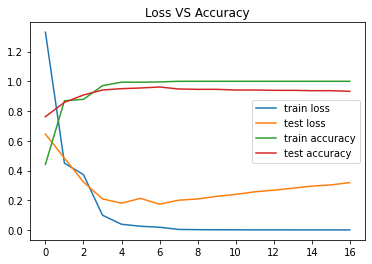

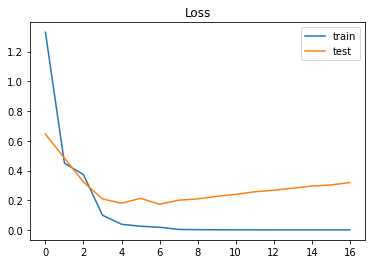

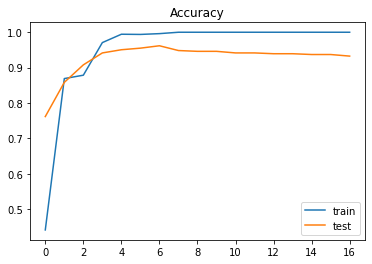

(None, None, None)

In [72]:
plot_graphs(hist21),loss_graph(hist21),acc_graph(hist21)

In [73]:
predicted = model21.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))

Acc: 93.26%
Precision: 0.93
Recall: 0.93
F1 score: 0.93


{'accuracy': 0.93, 'f1': 0.93, 'precision': 0.93, 'recall': 0.93}

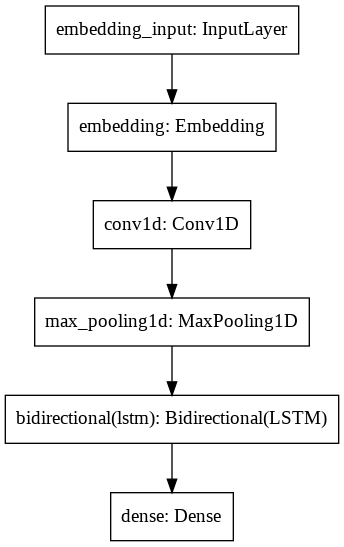

In [90]:
plot_model(model21)

In [ ]:

tf.keras.backend.clear_session()
model21 = Sequential()

model21.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model21.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model21.add(MaxPooling1D(pool_size=2))
model21.add(Bidirectional(LSTM(embedding_dim)))
model21.add(Dense(5, activation='softmax'))

model21.summary()
optim=#OPTIMIZER
model21.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_bi_lstms_n_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model21.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t21 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t21)
hist21=history

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 32)           12320     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 32)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               164864    
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 6,578,469
Trainable params: 6,578,469
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 17s 246ms/step - loss: 1.6049 - accuracy: 0.2484 - val_loss

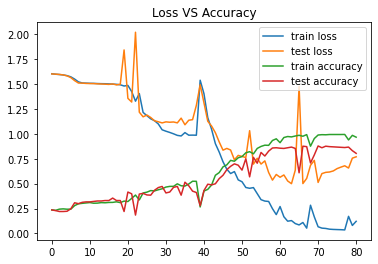

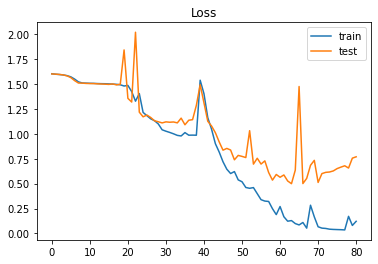

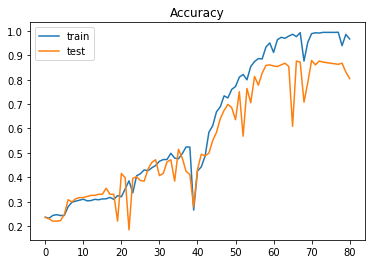

(None, None, None)

In [74]:
#With AdaGrad
tf.keras.backend.clear_session()
model22 = Sequential()

model22.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model22.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model22.add(MaxPooling1D(pool_size=2))
model22.add(Bidirectional(LSTM(embedding_dim)))
model22.add(Dense(5, activation='softmax'))

model22.summary()
optim=tf.keras.optimizers.Adagrad(
    learning_rate=0.01
)
model22.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_bi_lstms_n_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model22.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t22 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t22)
hist22=history

plot_graphs(hist22),loss_graph(hist22),acc_graph(hist22)

In [75]:
# Now we make predictions using the test data to see how the model performs

predicted = model22.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 80.45%
Precision: 0.80
Recall: 0.80
F1 score: 0.80


{'accuracy': 0.8, 'f1': 0.8, 'precision': 0.8, 'recall': 0.8}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 32)           12320     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 32)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               164864    
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 6,578,469
Trainable params: 6,578,469
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 16s 223ms/step - loss: 1.6074 - accuracy: 0.2088 - val_loss

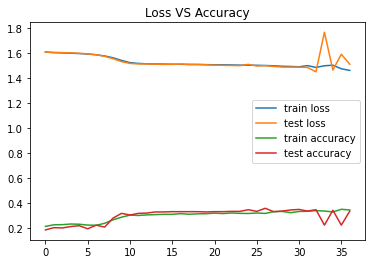

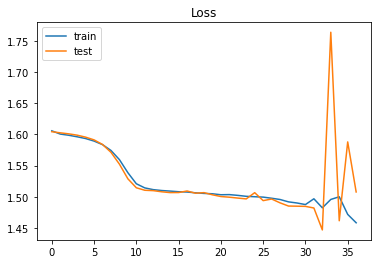

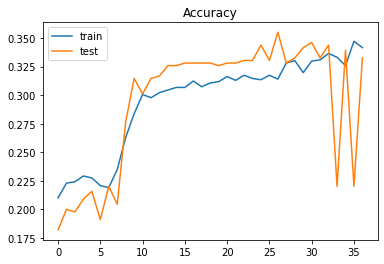

(None, None, None)

In [76]:
#With SGD
tf.keras.backend.clear_session()
model23 = Sequential()

model23.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model23.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model23.add(MaxPooling1D(pool_size=2))
model23.add(Bidirectional(LSTM(embedding_dim)))
model23.add(Dense(5, activation='softmax'))

model23.summary()
optim=tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.5, nesterov=True, name="SGD"
)
model23.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_bi_lstms_n_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model23.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t23 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t23)
hist23=history

plot_graphs(hist23),loss_graph(hist23),acc_graph(hist23)

In [77]:
# Now we make predictions using the test data to see how the model performs

predicted = model23.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 33.26%
Precision: 0.33
Recall: 0.33
F1 score: 0.33


{'accuracy': 0.33, 'f1': 0.33, 'precision': 0.33, 'recall': 0.33}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 32)           12320     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 32)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               164864    
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 6,578,469
Trainable params: 6,578,469
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 19s 267ms/step - loss: 1.7584 - accuracy: 0.2810 - val_loss

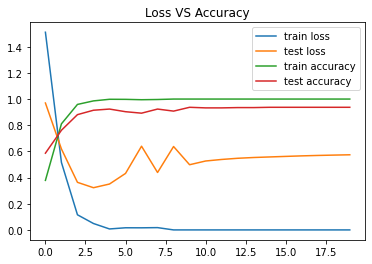

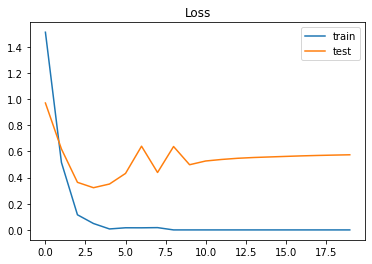

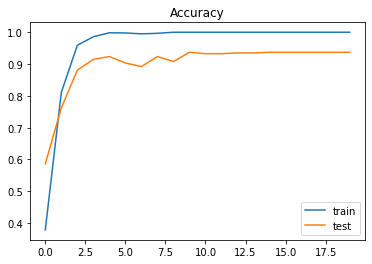

(None, None, None)

In [78]:
#With RMSProp
tf.keras.backend.clear_session()
model24 = Sequential()

model24.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model24.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model24.add(MaxPooling1D(pool_size=2))
model24.add(Bidirectional(LSTM(embedding_dim)))
model24.add(Dense(5, activation='softmax'))

model24.summary()
optim=tf.keras.optimizers.RMSprop(
    learning_rate=0.01
)
model24.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_bi_lstms_n_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model24.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t24 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t24)
hist24=history

plot_graphs(hist24),loss_graph(hist24),acc_graph(hist24)

In [79]:
# Now we make predictions using the test data to see how the model performs

predicted = model24.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 93.71%
Precision: 0.94
Recall: 0.94
F1 score: 0.94


{'accuracy': 0.94, 'f1': 0.94, 'precision': 0.94, 'recall': 0.94}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          6400000   
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 32)           12320     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 32)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               164864    
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 6,578,469
Trainable params: 6,578,469
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
56/56 [==============================] - 20s 265ms/step - loss: 1.6103 - accuracy: 0.1881 - val_loss

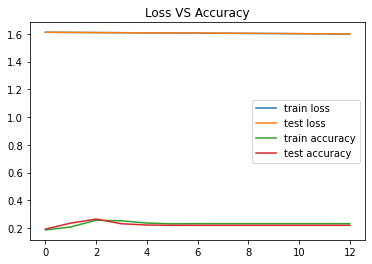

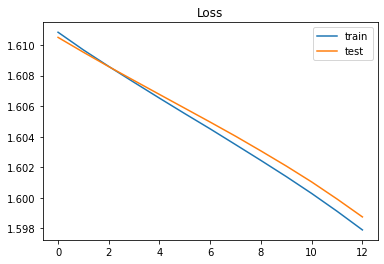

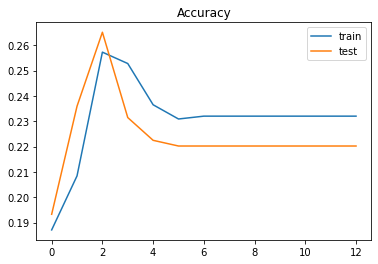

(None, None, None)

In [80]:
#With Adadelta
tf.keras.backend.clear_session()
model25 = Sequential()

model25.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model25.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model25.add(MaxPooling1D(pool_size=2))
model25.add(Bidirectional(LSTM(embedding_dim)))
model25.add(Dense(5, activation='softmax'))

model25.summary()
optim=tf.keras.optimizers.Adadelta(
    learning_rate=0.01
)
model25.compile(
    loss='categorical_crossentropy',
    optimizer=optim,
    metrics=['accuracy'],
)

epochs = 150
batch_size = 32
filepath="weights_best_bi_lstms_n_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)]


history = model25.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
t25 = time.perf_counter() - start
print('Total time took for training %.3f seconds.' % t25)
hist25=history

plot_graphs(hist25),loss_graph(hist25),acc_graph(hist25)

In [81]:
# Now we make predictions using the test data to see how the model performs

predicted = model25.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 22.02%
Precision: 0.22
Recall: 0.22
F1 score: 0.22


{'accuracy': 0.22, 'f1': 0.22, 'precision': 0.22, 'recall': 0.22}

## Overall Evaluation of all Models

In [82]:
print("Final Performance Of All Models : \n")
print("Model 1 - CNN-1D \n")





print("With Adam : \n")
mod1=model_eval(model,train_padded,training_labels,validation_padded,validation_labels)
print("With AdaGrad : \n")
mod2=model_eval(model2,train_padded,training_labels,validation_padded,validation_labels)
print("With SGD : \n")
mod3=model_eval(model3,train_padded,training_labels,validation_padded,validation_labels)
print("With RMSProp : \n")
mod4=model_eval(model4,train_padded,training_labels,validation_padded,validation_labels)
print("With AdaDelta : \n")
mod5=model_eval(model5,train_padded,training_labels,validation_padded,validation_labels)

print("Model 2 - LSTM \n")

print("With Adam : \n")
mod6=model_eval(model6,train_padded,training_labels,validation_padded,validation_labels)
print("With AdaGrad : \n")
mod7=model_eval(model7,train_padded,training_labels,validation_padded,validation_labels)
print("With SGD : \n")
mod8=model_eval(model8,train_padded,training_labels,validation_padded,validation_labels)
print("With RMSProp : \n")
mod9=model_eval(model9,train_padded,training_labels,validation_padded,validation_labels)
print("With AdaDelta : \n")
mod10=model_eval(model10,train_padded,training_labels,validation_padded,validation_labels)


print("Model 3 - BiDirectional LSTM \n")
mod11=model_eval(model11,train_padded,training_labels,validation_padded,validation_labels)
print("With AdaGrad : \n")
mod12=model_eval(model12,train_padded,training_labels,validation_padded,validation_labels)
print("With SGD : \n")
mod13=model_eval(model13,train_padded,training_labels,validation_padded,validation_labels)
print("With RMSProp : \n")
mod14=model_eval(model14,train_padded,training_labels,validation_padded,validation_labels)
print("With AdaDelta : \n")
mod15=model_eval(model15,train_padded,training_labels,validation_padded,validation_labels)

print("Model 4 - CNN 1-D + LSTM \n")

print("With Adam : \n")
mod16=model_eval(model16,train_padded,training_labels,validation_padded,validation_labels)
print("With AdaGrad : \n")
mod17=model_eval(model17,train_padded,training_labels,validation_padded,validation_labels)
print("With SGD : \n")
mod18=model_eval(model18,train_padded,training_labels,validation_padded,validation_labels)
print("With RMSProp : \n")
mod19=model_eval(model19,train_padded,training_labels,validation_padded,validation_labels)
print("With AdaDelta : \n")
mod20=model_eval(model20,train_padded,training_labels,validation_padded,validation_labels)

print("Model 5 - CNN 1-D + Bi Directional LSTM \n")

print("With Adam : \n")
mod21=model_eval(model21,train_padded,training_labels,validation_padded,validation_labels)
print("With AdaGrad : \n")
mod22=model_eval(model22,train_padded,training_labels,validation_padded,validation_labels)
print("With SGD : \n")
mod23=model_eval(model23,train_padded,training_labels,validation_padded,validation_labels)
print("With RMSProp : \n")
mod24=model_eval(model24,train_padded,training_labels,validation_padded,validation_labels)
print("With AdaDelta : \n")
mod25=model_eval(model25,train_padded,training_labels,validation_padded,validation_labels)

Final Performance Of All Models : 

Model 1 - CNN-1D 

With Adam : 



Model Loss on training data  0.0006858184351585805
Model Accuracy on training data:  1.0
Model Loss on validation data 0.2146340161561966
Model Accuracy on validation data:  0.9483146071434021


With AdaGrad : 



Model Loss on training data  0.1502213329076767
Model Accuracy on training data:  0.983146071434021
Model Loss on validation data 0.30992230772972107
Model Accuracy on validation data:  0.901123583316803


With SGD : 



Model Loss on training data  0.3210820257663727
Model Accuracy on training data:  0.9213483333587646
Model Loss on validation data 0.4662724435329437
Model Accuracy on validation data:  0.8426966071128845


With RMSProp : 



Model Loss on training data  4.1653380321804434e-05
Model Accuracy on training data:  1.0
Model Loss on validation data 0.44063177704811096
Model Accuracy on validation data:  0.9370786547660828


With AdaDelta : 



Model Loss on training data  1.5962117910385132
Mod

In [83]:


table = PrettyTable()

table.field_names = ['Model [With Optimiser]', 'Accuracy','Time Taken To Train (secs)']
print("Metrics Analysis without GPU : \n")
table.add_row(['CNN-1D [Adam]',round(mod1[1][1]*100,2),round(t1,2)])
table.add_row(['CNN-1D [AdaGrad]', round(mod2[1][1]*100,2),round(t2,2)])
table.add_row(['CNN-1D [SGD]', round(mod3[1][1]*100,2),round(t3,2)])
table.add_row(['CNN-1D [RMSProp]', round(mod4[1][1]*100,2),round(t4,2)])
table.add_row(['CNN-1D [AdaDelta]', round(mod5[1][1]*100,2),round(t5,2)])

table.add_row(['LSTM [Adam]',round(mod6[1][1]*100,2),round(t6,2)])
table.add_row(['LSTM [AdaGrad]', round(mod7[1][1]*100,2),round(t7,2)])
table.add_row(['LSTM [SGD]', round(mod8[1][1]*100,2),round(t8,2)])
table.add_row(['LSTM [RMSProp]', round(mod9[1][1]*100,2),round(t9,2)])
table.add_row(['LSTM [AdaDelta]', round(mod10[1][1]*100,2),round(t10,2)])



table.add_row(['Bidirectional LSTM [Adam]',round(mod11[1][1]*100,2),round(t11,2)])
table.add_row(['Bidirectional LSTM [AdaGrad]', round(mod12[1][1]*100,2),round(t12,2)])
table.add_row(['Bidirectional LSTM [SGD]', round(mod13[1][1]*100,2),round(t13,2)])
table.add_row(['Bidirectional LSTM [RMSProp]', round(mod14[1][1]*100,2),round(t14,2)])
table.add_row(['Bidirectional LSTM [AdaDelta]', round(mod15[1][1]*100,2),round(t15,2)])



table.add_row([' CNN-1D + LSTM  [Adam]',round(mod16[1][1]*100,2),round(t16,2)])
table.add_row([' CNN-1D + LSTM  [AdaGrad]', round(mod17[1][1]*100,2),round(t17,2)])
table.add_row([' CNN-1D + LSTM  [SGD]', round(mod18[1][1]*100,2),round(t18,2)])
table.add_row([' CNN-1D + LSTM  [RMSProp]', round(mod19[1][1]*100,2),round(t19,2)])
table.add_row([' CNN-1D + LSTM  [AdaDelta]', round(mod20[1][1]*100,2),round(t20,2)])



table.add_row([' CNN-1D + Bidirectional LSTM  [Adam]',round(mod21[1][1]*100,2),round(t21,2)])
table.add_row([' CNN-1D + Bidirectional LSTM  [AdaGrad]', round(mod22[1][1]*100,2),round(t22,2)])
table.add_row([' CNN-1D + Bidirectional LSTM  [SGD]', round(mod23[1][1]*100,2),round(t23,2)])
table.add_row([' CNN-1D + Bidirectional LSTM  [RMSProp]', round(mod24[1][1]*100,2),round(t24,2)])
table.add_row([' CNN-1D + Bidirectional LSTM  [AdaDelta]', round(mod25[1][1]*100,2),round(t25,2)])


print(table)

Metrics Analysis without GPU : 

+------------------------------------------+----------+----------------------------+
|          Model [With Optimiser]          | Accuracy | Time Taken To Train (secs) |
+------------------------------------------+----------+----------------------------+
|              CNN-1D [Adam]               |  94.83   |           222.18           |
|             CNN-1D [AdaGrad]             |  90.11   |           390.87           |
|               CNN-1D [SGD]               |  84.27   |           266.74           |
|             CNN-1D [RMSProp]             |  93.71   |            63.8            |
|            CNN-1D [AdaDelta]             |  22.02   |           42.68            |
|               LSTM [Adam]                |  62.02   |           374.47           |
|              LSTM [AdaGrad]              |  49.66   |           804.92           |
|                LSTM [SGD]                |  32.58   |           339.73           |
|              LSTM [RMSProp]   

In [84]:
print(table.get_string(sortby='Accuracy',reversesort=True))

+------------------------------------------+----------+----------------------------+
|          Model [With Optimiser]          | Accuracy | Time Taken To Train (secs) |
+------------------------------------------+----------+----------------------------+
|       Bidirectional LSTM [RMSProp]       |  95.06   |           692.18           |
|              CNN-1D [Adam]               |  94.83   |           222.18           |
|        Bidirectional LSTM [Adam]         |  94.61   |           928.49           |
|             CNN-1D [RMSProp]             |  93.71   |            63.8            |
|  CNN-1D + Bidirectional LSTM  [RMSProp]  |  93.71   |           286.21           |
|              LSTM [RMSProp]              |  93.26   |           530.43           |
|    CNN-1D + Bidirectional LSTM  [Adam]   |  93.26   |           298.69           |
|         CNN-1D + LSTM  [RMSProp]         |  92.58   |           194.83           |
|       Bidirectional LSTM [AdaGrad]       |  91.69   |          

In [85]:
print(table.get_string(sortby='Time Taken To Train (secs)',reversesort=True))

+------------------------------------------+----------+----------------------------+
|          Model [With Optimiser]          | Accuracy | Time Taken To Train (secs) |
+------------------------------------------+----------+----------------------------+
|       Bidirectional LSTM [AdaGrad]       |  91.69   |          1945.81           |
|         Bidirectional LSTM [SGD]         |   37.3   |          1471.35           |
|  CNN-1D + Bidirectional LSTM  [AdaGrad]  |  80.45   |           983.69           |
|        Bidirectional LSTM [Adam]         |  94.61   |           928.49           |
|         CNN-1D + LSTM  [AdaGrad]         |  86.29   |           889.51           |
|           CNN-1D + LSTM  [SGD]           |  57.08   |           881.22           |
|              LSTM [AdaGrad]              |  49.66   |           804.92           |
|       Bidirectional LSTM [RMSProp]       |  95.06   |           692.18           |
|           CNN-1D + LSTM  [Adam]          |  86.52   |          